In [4]:
import mido

class Note:
    def __init__(self, notetype, time, pitch):
        self.type = notetype
        self.time = time
        self.pitch = pitch

    def toString(self):
        return ("Note: {{type: {}, time: {}, pitch: {}}}".format(self.type, self.time, self.pitch))


def get_all_notes(track_no, midi_file):
    note_ons = []
    note_offs = []
    total_time = 0

    for msg in midi_file.tracks[track_no]:

        if msg.type == 'note_on':
            note = Note(msg.type, total_time, msg.note)
            note_ons.append(note)

        if msg.type == 'note_off':
            note = Note(msg.type, total_time, msg.note)
            note_offs.append(note)

        total_time += msg.time

    return note_ons, note_offs


def get_high_voice(notes_arr):
    high_voice = []
    notes_by_time = {}
    for note in notes_arr:
        notes_by_time.setdefault(note.time, []).append(note)

    for chord in notes_by_time.values():
        highest = get_highest_note(chord)
        if highest != None:
            high_voice.append(highest)

    return high_voice


def get_highest_note(notes_array):
    if len(notes_array) == 0:
        return None

    highest_note = notes_array[0]

    for note in notes_array:
        if note.pitch > highest_note.pitch:
            highest_note = note

    return highest_note


def build_vec(melody, notes_off):
    if len(melody) == 0:
        return []
    else:
        last_note_on = melody[len(melody) - 1]

    if len(notes_off) == 0:
        vec_len = last_note_on.time
    else:
        last_note_off = notes_off[len(notes_off) - 1]
        vec_len = max(last_note_on.time, last_note_off.time)

    vec = [0] * vec_len

    for i, note in enumerate(melody):
        if i == len(melody) - 1:
            next_note_off = get_next_note_by_pitch(notes_off, note.pitch, note.time)

            if next_note_off == None:
                return vec
            else:
                for j in range(note.time, next_note_off.time):
                    vec[j] = note.pitch
                return vec


        next_note_on = melody[i + 1]
        next_note_off = get_next_note_by_pitch(notes_off, note.pitch, note.time)

        if next_note_off == None or next_note_off.time >= next_note_on.time:
            end = next_note_on.time
        else:
            end = next_note_off.time

        for j in range(note.time, end):
            vec[j] = note.pitch


def get_next_note_by_pitch(notes_arr, pitch, time):
    for note in notes_arr:
        if note.time < time or note.pitch != pitch:
            continue
        else:
            return note
    return None


def get_melody_track_no(midi_file):
    track = None
    means = []
    for i, track in enumerate(midi_file.tracks):
        pitches = []
        for msg in track:
            if msg.type == 'note_on':
                pitches.append(msg.note)

        means.append(0)
        if len(pitches) != 0:
            means[i] = sum(pitches)
            means[i] /= len(pitches)

    highest_mean = 0
    for i, mean in enumerate(means):
        if mean > highest_mean:
            track = i
            highest_mean = mean

    return track


def midi_to_vec(midi_path):
    midi = mido.MidiFile(midi_path)
    track = get_melody_track_no(midi)
    melody, breaks = get_all_notes(track, midi)
    high_voice = get_high_voice(melody)
    return build_vec(high_voice, breaks)


<IPython.core.display.Javascript object>


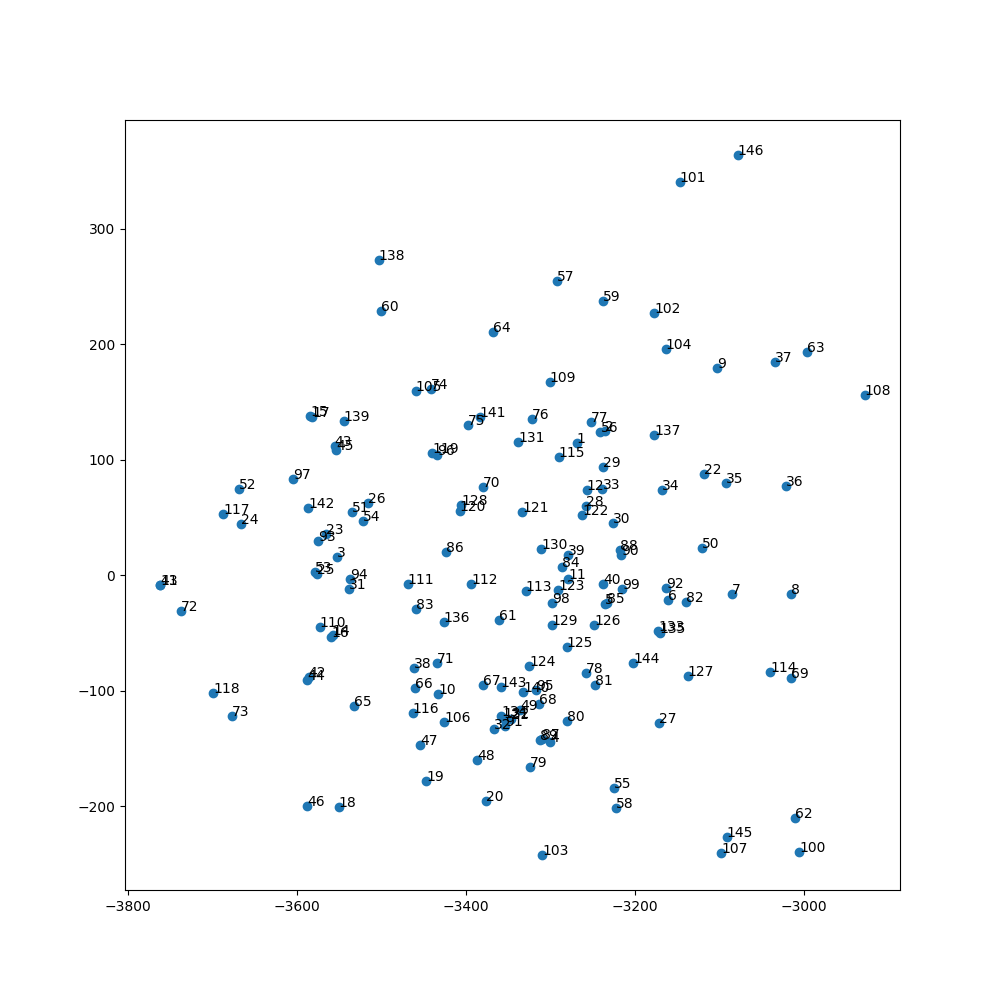

In [34]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

midi_path = '../assets/archive/mozart/mz_545_1.mid'
n_measures = 146
vec = midi_to_vec(midi_path)

size_of_measure = int(len(vec) / n_measures)
size_of_vec = size_of_measure * n_measures

A = np.array(vec[0:size_of_vec]).reshape(n_measures, size_of_measure).transpose()
B, D, Q = np.linalg.svd(A, full_matrices = False)
C = np.diag(D) @ Q

B = B[:, 0:2]
C = C[0:2, :]

# for i in range(len(C[0])):
#     x = C[0, i]
#     y = C[1, i]
#     norm = np.sqrt(x*x + y*y)
#     x /= norm
#     y /= norm
#     C[0, i] = x
#     C[1, i] = y

xvals = C[:1, :]
yvals = C[1:, :]

fig, ax = plt.subplots()
ax.scatter(xvals[0], yvals[0])
for i in range(len(xvals[0])):
    ax.annotate(i+1, (xvals[0, i], yvals[0, i]))
    
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()
